In [1]:
import sys
sys.path.append('../../fairseq')
# sys.path.append('./scripts')
# sys.path.append('./scripts/g2p')

import os
import string
import pathlib
import numpy as np
import pandas as pd
import librosa


from tqdm.notebook import tqdm
from glob import glob
from g2p.en_us import G2P

import torch
import fairseq
import soundfile as sf

from itertools import groupby

In [2]:
data_dir = '/mnt/d/projects/mm_data_splited'
checkpoint_path = '/mnt/d/projects/semi/results/finetune_base_vc copy/checkpoint_best.pt'
dict_path = '/mnt/d/projects/semi/data/dict.wrd.txt'

g2p = G2P()
remove_digits = str.maketrans('', '', string.digits)

In [3]:
wav_path_list = glob(os.path.join(data_dir, '*.mp3'))+glob(os.path.join(data_dir, '*.m4a'))+glob(os.path.join(data_dir, '*.wav'))+glob(os.path.join(data_dir, '*.aac'))
len(wav_path_list)

63

In [4]:
wav_path_list

['/mnt/d/projects/mm_data_splited/A1-1.mp3',
 '/mnt/d/projects/mm_data_splited/A1-2.mp3',
 '/mnt/d/projects/mm_data_splited/A1-3.mp3',
 '/mnt/d/projects/mm_data_splited/A2-1.mp3',
 '/mnt/d/projects/mm_data_splited/A2-2.mp3',
 '/mnt/d/projects/mm_data_splited/A2-3.mp3',
 '/mnt/d/projects/mm_data_splited/A3-1.mp3',
 '/mnt/d/projects/mm_data_splited/A3-2.mp3',
 '/mnt/d/projects/mm_data_splited/A3-3.mp3',
 '/mnt/d/projects/mm_data_splited/A4-1.mp3',
 '/mnt/d/projects/mm_data_splited/A4-2.mp3',
 '/mnt/d/projects/mm_data_splited/A4-3.mp3',
 '/mnt/d/projects/mm_data_splited/A5-1.mp3',
 '/mnt/d/projects/mm_data_splited/A5-2.mp3',
 '/mnt/d/projects/mm_data_splited/A5-3.mp3',
 '/mnt/d/projects/mm_data_splited/A6-1.mp3',
 '/mnt/d/projects/mm_data_splited/A6-2.mp3',
 '/mnt/d/projects/mm_data_splited/A6-3.mp3',
 '/mnt/d/projects/mm_data_splited/B1-1.mp3',
 '/mnt/d/projects/mm_data_splited/B1-2.mp3',
 '/mnt/d/projects/mm_data_splited/B1-3.mp3',
 '/mnt/d/projects/mm_data_splited/B2-1.mp3',
 '/mnt/d/p

In [5]:
phone_seq_dict = dict()
for part in [1,2,3]:
    prompt_path = os.path.join(data_dir, f'Part{part}.TXT')
    with open(prompt_path) as f:
        lines = f.readlines()
        s = ''.join([l.replace('\n', ' ') for l in lines])
    phone_seq = []
    for word in s.split(' '):
        if word in ['–', '…', '']:
            continue
        phone_seq += [x.lower().translate(remove_digits) for x in g2p.convert(word.translate(str.maketrans('', '', string.punctuation)))]
    phone_seq = ' '.join(phone_seq)  
    phone_seq_dict[part] = phone_seq

In [6]:
phone_seq

'hh m s eh d dh ah s ah n l uh k ih ng th ao t f ah l ay hh ae v ae n ay d iy ah l eh t s hh ae v ah k aa n t eh s t t uw s iy w ih ch ah v ah s ih z dh ah s t r ao ng er ay n ow hh uw w ih l w ih n s eh d dh ah w ay n d w iy sh ae l s iy r ih p l ay d dh ah s ah n d uw y uw s iy dh ae t m ae n d aw n dh eh r dh ah w ay n d l uh k t w eh r dh ah s ah n w aa z p oy n t ih ng ah y ah ng m ae n w aa z w ao k ih ng ah l ao ng ah w ih n d iy r ow d th r uw dh ah m aw n t ah n z ih t w aa z s ow k ow l d hh iy w aa z w eh r ih ng ah hh eh v iy w ih n t er k ow t t uw k iy p w ao r m l eh t s s iy w ih ch w ah n ah v ah s ih z s t r ao ng ih n ah f t uw t ey k hh ih z k ow t ao f hh ih m s ah jh eh s t ih d dh ah s ah n iy z iy ay k ae n d uw dh ae t ih n n ow t ay m b ow s t ah d dh ah w ay n d g ow aa n dh eh n s eh d dh ah s ah n ih l w aa ch y uw f r ah m b ih hh ay n d ah k l aw d dh ah w ay n d b l uw ah n d b l uw ih t b l uw s ow hh aa r d dh ae t dh ah b er d z hh ae d t uw k l ih ng

In [7]:
class Decoder:
    def __init__(self, json_dict):
        self.dict = json_dict
        self.look_up = np.asarray(list(self.dict.keys()))

    def decode(self, ids):
        converted_tokens = self.look_up[ids]
        fused_tokens = [tok[0] for tok in groupby(converted_tokens)]
        output = ' '.join([tok for tok in fused_tokens if tok != '<s>'])
        return output
    
device = torch.device('cuda')

model, _ = fairseq.checkpoint_utils.load_model_ensemble(
    [checkpoint_path], arg_overrides={})
model = model[0]
model.eval()

model.to(device=device)

json_dict = {"<s>": 0, "<pad>": 1, "</s>": 2, "<unk>": 3}
count = 4
with open(dict_path, 'r') as f:
    for line in f.readlines():
        json_dict[line.split(' ')[0].strip()] = count
        count += 1

decoder = Decoder(json_dict=json_dict)


decoded_dict = dict()
for wav_path in tqdm(wav_path_list):
    wav_id = wav_path.split('/')[-1].split('.')[0]
    with torch.no_grad():
        wav, sr = librosa.load(wav_path.strip())
        if sr != 16000:
            wav = librosa.resample(wav, orig_sr=sr, target_sr=16000)
        input_sample = torch.tensor(wav)[None, :].to(torch.float32).to(device=device)

        logits = model(source=input_sample, padding_mask=None)["encoder_out"]
        predicted_ids = torch.argmax(logits[:, 0], axis=-1).cpu()

    phn_seq = decoder.decode(predicted_ids)

    decoded_dict[wav_id] = phn_seq
    print(wav_id)
    print(phn_seq)

  0%|          | 0/63 [00:00<?, ?it/s]

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A1-1
sil dh ih s sil t r ay sil t r iy sil m eh zh er sil ey sh uw sil b r l uw sil l iy f sil k r uw sil f ah sil t ao sil k er f iy sil t er n aa n sil t er n aa n dh ah l ay s sil p l iy s sil sil dh eh r w s ah sil b ih sil k sil p r aa sil b l ah m sil b iy sil t ih n d ih sil t uw sil g r uw sil p s sil dh ah sil g aa m ah n t ih s sil t r ay ih sil t uw ah sil d r eh th iy ih sh uw ah v hh ow m l ah s sil n ah s sil hh iy l er n d hh aw sil t uw sil d r ay w ih n hh iy w ao s ih sil k s sil t iy y ih z ow sil d sil hh ih s sil w ih zh ah w ah s sil b l ae r iy ae n d ih hh iy n iy sil g r ae s ih s sil t uw s iy sil sil sh iy w ah s sil d ah w ih z hh er w er sil k f ao dh ah sil d ey sil ae n d sil k uh ih l ay sil k s sil sh iy y uw z sil t ah sil b l ae n d er sil t uw m ey sil k ah sil sil m ow th ih f ao sil b r eh sil k f er s sil sh ih l ay sil k s sil t uh sil t ey sil k w ao sil k ih n dh ah sil p aa sil k eh v r ih m ao n iy ng sil dh ah s sil k uw s ih s sil t ah m n 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A1-2
sil sil ih sil t w ah z ah f ay n b ah t sil eh r ih sil k uh w ih n t er s sil d ey sil ae sil dh s aa n sh ow n d aw ng sil aa n dh ah s n ow ng k aw w er sil er sil p sil er s sil b ih l ow sil ah s ah sil b y uw t f ah s ay sil t sil ey th ao t sil ae n l uh k ae dh ah l ey t ah w ay sil t s aw s ah v sil dh ah sh ih p ao n dh sil b l uw s iy sil ay w ao n t ah t ih sil k m ay t ae sil t r aa v ah l ih ng ah sil k r ao s dh ah s sil k ay sil t ah d ey sil aa f sil t er ao sil w t ah sil w ah s ah r aa sh sil s ah d ah n l iy sil ah v r iy z ih k sil b l aa s ah v ay er sil s sil k r ih sh sil t sil p aa t sil n d sil n ih r l ah sil b l uw d ah s ao ng ah l ao ng w ih dh ih sil t sil ao t ah v sil m ay w ey s ah n sil r ow dh ah w ih n d sil s iy dh ow sh ih p s sil aa m sil g ow ng t uw sil b l ow dh ow m r ow sil ah sil b l ow dh ah m r ay t ah v sil k ao s sil l ih t uw sil ah dh ih w uh n ow w ah s hh dh ah sil dh ah w ih n d sil b l uw ae n b l uw ih sil b l s ow hh aa dh

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A1-3
sil sil s ae sil dh ah s ah n sil l uh k ih ng th ao t f ah l iy sil ay hh ae v ah ay sil d iy sil dh eh s hh ae v ah sil k aa n t ae sil k s t uw s iy w uh sh ah v ah s ih ah sil f r ao ng sil l ah ih s ah sil ih l ah sil s sil ey z l ah sil s t r ao ng g er sil ay n ow hh uw w ih w ih n s ae dh ah w ih sil w ih sh aa s iy sil r ih sil p ae dh ah s ah n sil d uw y uw s iy dh ah m ae n d aw dh eh r sil dh ah w ih n d ih l uh sil k t w ih n d ah s aa w s sil p ao n t ih ng sil ah y ah ng m ae w ah sil w ao k ih ng sil ah l ao sil ah y ah ng m ah w ah s w ao k ih ng ah l ao ah w ih n d ow sil ah w ih n d ih ng r ow sil t sil sil th r uw d ah m ao ng t n sil ih t w ah s ow sil k ow sil d sil sh uw w ah z w eh ih ng ah hh ae v ih sil hh ae w ah w ih n t ah sil k ow t uw sil k iy sil w m sil ae s iy w ih sh ah v sil w ih sh w ah n ah f s ih s t r ao ng g er sil iy v ih n t uw sil t ey k hh ih s sil k ow ch ao th ah sil hh ih s sil k ow d ao f hh ih m sil s ah sil jh eh s ih dh ah s ah 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A2-1
sil n iy s sil t ay sil sil t r iy sil m ey er sil iy sh uw sil sil b l uw sil l iy sil sil g er sil sil v ah sil t aa sil g er f iy sil t er aa n sil sil t er aa n dh ah l ay z sil p l iy s sil sil dh eh w ah z ah sil b ih sil p r aa sil b l ah m sil b ih sil t ih n z ah sil t uw sil g r uw s sil sil dh ah sil g aa ah m ah n d eh sh ay n sil t uw ah sil d r ay s iy y uw sh uw ah f hh ow m l ih s n s sil sil hh ae l er n d hh aa sil t uw sil d r ay w ah sil hh ey w ah dh s ih sil k s sil t iy n y ih r z ow sil d sil hh ih m ih ah w ah z sil l eh iy sil ah n d ah hh ih m ih sil d ih sil dh ih sil g ae s ih z sil t uw s iy sil sil sh iy w ah z sil d aa m ih hh er w ao sil k f ao dh ah sil d ey sil ah n ah sil k uw sil d ih r ih l ae sil k s sil sil sh iy y ow s ah sil b l ae n sil d er sil t uw m ey sil k ah s ih s f ao r ae sil k f er s sil sil iy l ae s sil t uw sil t ih sil k ah w er sil k ih n dh ah sil p aa r sil g ay r ih m ao n ih ng sil sil dh ah s sil k uw s ih s sil t ah m

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A2-2
sil ih t ah w ah z ah f ae n ae t ah m ay r iy k ow t ah v ih n t er s t ey sil ae z ah s ah n sh ao n d ao ao n dh ah s n ow k aa er d er s sil b ih l ow sil sil w ah z ah sil b y ih t ah f ah s ay s sil ey s ao t sil sil ah n d ah l uw k ae z ah l ih t ah sil r aa t s eh s sil ah f dh ah sh ih p s ah n dh ah sil b l uw s iy sil sil ay m aa n t uw t ih k m ay t aa n t aa er ih ng ah k ao s ah k ae t dh ey sil f t er ao sil w ah s l er r aa sh sil ah ah n ey sil ah f r iy dh ah n k ow d ah sil b l ae s ah f eh er s sil k r uw n d p aa s t sil ah n ih r l sil b ih l ow dh ah s ah ah l ao w ih z ey sil aa t ah v f sil m ay v ey sil s ao sil r ao dh ah v ih n d sil s iy dh ih s sh iy p s sil ah n sil g ow ih ng t uw sil b b l ow dh ah n zh r ae t f sil k ao r s sil m ow n s ow w ow s iy z ah n sil l ah v ih n sil b l uw ah n sil b l uw sil ih z sil b l uw s ow hh aa dh ae z dh ah sh ih p s ah s eh s r ih ah sil ah p aa r t sil ao dh ah s ah ng sil k d ah sil d uw sil w ah z ah w ah s

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A2-3
sil sil sil s ae n z ah s ah sil l uw k ih ng s ao t f ao sil ah hh ae l ay d iy sil dh ae s hh ae w ah k aa n t ae s t uw s iy v ih sh ah f aa s ih z ah s t r ah ng g er sil sil ay n ao uw eh v ih sil s ae dh ah v ih n d sil r ey sh s iy sil r ih sil p l ay z ah s sil d uw s ih dh ae s m ae sil d aa dh eh r sil dh ah w ih n d ah l uw k dh ah r eh ah s ah m ah z sil p ah n t iy sil ah y ah m ah w ah z ah w ao k ih ng ah l ao r ih n d ih r ow d sil s r uw z ah m ah n t ah n s sil eh t w ah s ow k ao d sil eh w z r eh ih ah hh ae v ih r ih n t er k t sil t uw k eh sil w ao sil dh ae s ih r ih sh r ah f aa s ih s t r ao sil ih s t r ao n aa t uw t ih k hh s k ao t ao f hh eh sil s ah jh ae s sil t eh dh ah s ah n sil iy dh ah sil ay k ah n d uw dh aa s ih n n ao t ah n sil s ih ah m ih n sil sil ah s ah sil ae v r eh w sh ah f r ah n b ih hh ae n ah k l ao t sil sil l ah ih n sil b l ow ah n sil b l uw sil ae n ah b l uw s ow hh aa ae z ah sil p er s hh ae t uw ih n t uw ah ch r ih s

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A3-1
sil sil d ih s sil t w ay sil t r iy m sil m eh zh er sil ey sh uw sil b r l uw sil l ey sil g er sil f ah t ow g r er f iy sil t hh er ao n sil t r er aa n d ah l ay s p l iy s sil d eh r w ah s ah b p r aa b l ah m b ih t w iy ih n d ah t uw g r uw p s sil d ah sil g aa r ah m ah n t sil ih s t r ay ng t uw ah d r eh s d ih s sil iy sh uw ah v hh ow m l iy s n ah s sil hh iy l er n d hh aw t uw d r ay b ah n sil hh w ih n hh iy w ah z s ih k s t iy n y z ow l d sil sil hh ih z v iy zh ah n w ah b l er iy sil ah n d hh iy n iy d ih d k l aa* s ih s t uw s iy sil sh iy w ah s d ah n w ih th hh er w er k sil f ao dh ah d ey sil ah n d k uh d r ih l ae k s sil sh iy y uw s d ah b l eh n d er t uw m ey k ah s m uw th iy sil f er b r eh k f ah s t sil sh iy l ae k s t uw t ey k ah w ao k sil ih n d ah p aa r k sil eh v r iy m ao r n ih ng sil d ah s k uw l s ih s s t ah m n iy s m ao r f ah n t iy ng sil t uw iy m p r uw v eh jh ah k ey sh ah n sil d ah b ih d ih ng z aa r k ah t eh k

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A3-2
sil ih t w ah z ah f ay n b ah t v eh r iy k uh d w ih n t er s d ey sil ah z dh ah s ah n sh ow n d aw ng sil ao n dh ah s n ow k ah v er d er th b ih l ow sil w ah t ah b y uw t ah f ah s ay t sil ih t s th ao t sil ah n d l uw k ae t d ah l t ah sil w ay t s iy l s ah v dh ah sh ih p s ah v dh ah b l uw s iy sil ay w ao n t ah t ey k m ay t ae m t r v l ih ng ah k r ao s dh ah s k ay t ah l iy sil aa* f t ao l sil w ao s ah r ah sh sil s ah d ah n l iy sil ah f r iy z ih ng k ow d sil b l aa s t ah v eh r sil s k r iy ch p aa s t sil ah n d n ih r l iy r uw dh ah s ah n ah l ao ng w ih dh ih t sil sil aw t ah v m ay w ey s eh sil r ao r z ah dh ah w iy n t sil s iy d uw s r iy p s sil ah n d g ih ng t uw b l ow dh ah ao r eh t ah v k ao r s sil d ey w ao t s n ow w s hh ih t hh iy d l ah m sil sil d ah w ih n b l uw ah n d b l uw sil ih t b l uw s ow hh aa r d sil dh ah t sh ih p s ey w l s r ih p t ah p aa r t sil ao dh ah s ah n k uh t d uw w ah s w ao sh ah z ah s ey t er s 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A3-3
sil sil sil s d s eh n sil l uw k ih ng th ao t f ah l sil ay hh ae v ah ay d iy r sil l ae s hh ae v ah k aa n t eh s t sil t ah s iy w ih ch ah v ah s s d ah s t r ao ng g er sil ay n ow sil hh uw w w iy n s eh d ah w sil w ih sh ao s iy sil r ih p l ay dh ah s ah n sil t uw s iy d ah t m ah n d aw d eh r sil d ah w iy n d l uw t w eh r dh ah s ah n w ah s p oy n t ih ng sil ah y ah ng m ae n w ah z w ow k ih ng l ao ng sil ah w ih n d iy r ow d sil th r* r uw d ah m aa n t ih n s sil ih t w ah s s ow k ow d hh iy w uh s w eh ih ng ah hh ae v iy w ih n d er k ow ch t k iy p w ao sil d ah t s iy w ih sh w ah v ah z ih s t r ao ng ih n ah f t ah t ey k hh ih s k ow t ao f hh ih m sil s ah zh jh eh s ih d d ah s eh n sil iy z l iy sil sil ay k ah n d uw dh t iy n ow t hh ae m sil b uh s ih d ah w iy ng t sil g ow ao ng dh ah n sil s eh d ah s ah n sil ay w ow sh uw f r ah m b iy hh ay n d ah k l t sil sil sil sil d ah w iy n b l uw ah n d b l uw sil t b l uw s ow hh aa r t sil d ae

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A4-1
sil d ey s sil t r ay sil d r iy m sil m ae zh er sil iy s uw sil r uw sil l sil g er sil f ah t aa b er f iy sil t er n ao sil t er n ah n d ah l ay s p l iy s sil d eh r w ah s ah sil b ih k p r aa b l ah m sil b ih t w iy n d ah sil t uw sil g r uw p s sil d ah g ah v ah m ah n t sil ih z t r ay ih ng t uw sil ah d r eh s t d iy s uw ah v hh ow p l ah s n ah s sil hh iy l er n t sil hh aw t uw d r ay sil w eh n hh iy w ah s ih k s t iy n y r s ow d sil hh iy s v iy zh ah n sil w ah s p l er iy sil ah n hh iy n iy d ih d sil g l aa s ih s t uw s iy sil sh iy w ah s d aw sil w ih th hh er sil w er k f ao d ah d ey ah n k uw ih l ae k s sil sh iy y uw s t ah sil b l ae n d er t uw m ey k ah s m uw th l iy sil f ao b r eh k f ah s t sil sil sh iy l ae k s t uw t ih k ah w ao k sil ih n d ah p aa r k eh v r iy m ao n ih ng sil sil d ah s k uw l s ih s t ah m sil n iy z m ao f ah n d ih ng t uw ih m p r uw v sil ae d jh ah k ey sh ah n sil d ah b iy d iy n s aa k ah t eh k ch er w ah

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A4-2
sil ih t w ah z ah f ay sil b ah f eh r iy k ow d w ih n t er s t ey sil ah z dh ah s ah n sh ah n d aw ng sil ao n s n ow sil k ah v er d er th sil b ih l ow sil w ah t ah b uw t f uh s ay t sil ih t b ao t sil ah n l k ae n d ah l ih t uw w ay t s ey w s ah v dh ah sh ey p s sil ao n d ah b l uw s iy sil sil ah w aa n t ah t hh ih m eh t ay m sil t r ae v ah l ih ng ah k r ao s ah s k ay t ah d ey sil aa f t ao sil w ah s ah r aa sh sil s ah d ah n l iy sil ah f r iy z ih ng k ow b l s v eh r s k r iy ch t sil p aa s t sil n ih r l iy sil b l uw dh ah s ah n ah l ao ng w ih th ih t sil aa t ah m ay w ey s ah n sil r ao r sil r ao d sil d ah w iy n sil s iy d ow s sh ey p s sil ah n g uw ng t uw b l ow d ah m r t sil ao th sil k ao s sil d ey w uh n n ow w ah s hh ih d ah m sil d ah w ih n b l uw sil ah n b l uw sil ih b l uw s ow hh aa d ae t sil d ah sh ih p s ey s sil r ih t ah p aa t sil ao dh ah s ah n k uh d uw sil w ah s w ao ch sil ah s d ah s ih l er s sh ih v er t sil i

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A4-3
sil s ae d ah s ah n sil l uw k ih ng th ao t f uh sil ay hh ae v ah n ah n ay d iy r sil l s hh ae w ah sil k aa n t ae s t sil t uw s iy w ih sh f ah s ih s ah s t r ao ng er sil ay n ow hh uw w iy ng sil s ae d ah w ih n sil w ih sh ih s iy sil r ih p l ay t sil d ah s ah n sil d uw s iy d ae t m ae n sil d aw n d eh r sil d ah w n d sil l uh k sil l k sil w eh d ah s ah ng w ah s p oy t ih ng sil ey y ah ng m ae n w ah s w ao k ih ng ah l ao ng ah w iy n d iy r sil th r uw d ah m aa n t ah n s sil ih w ah s k ow d sil hh iy w ah s w er ih ng ah hh eh v iy w iy n t er k ow t uw k iy p w ao m sil sil ae s s iy w ih ch ah n ah f ah s ih s t r ao ng g er sil ih s t r aa ng ih n ah f t uw t ih hh iy s k ow s ao f hh iy m sil s ah jh ae s t sil d ah s ah n sil iy z iy sil sil ay k ah n d uw d ae t iy n n t ay m sil b uw s t ey d sil d ah w n sil g ow ao sil dh eh n sil s ae d ah s n sil aw w ao t sh uw sil f r ah m b ih hh ay n d ah k l aw t sil d ah w ih n d sil b l uw sil ah n b l

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A5-1
d ey s sil t ay sil t r iy m sil m ae zh er sil iy sh uw sil b l uw sil l iy f sil g er sil f ah t aa g r er f iy sil t er n aa ng sil sil t er l aa n d l ay s sil p l ey s sil d eh r w ah z ah b ih k p r aa b l ah m b ih t w iy n d ah t uw g r ow p s sil d iy g aa f m ah n t sil ih s t r ay n t uw d r eh s t ah iy sh uw ah v hh ow m ah l ih s n ah s sil sil hh l er n t hh aw t ah d r ay w ih n hh iy w er s ih k s t iy n y ih r s ow t sil hh iy s b ih sh ah n w ah s l aa r iy ae n hh ey n iy d ih d sil k l aa s ih s t uw s iy sil sh iy w ah s t ah n w ih d hh er w er k f ao d ah d ey sil ae n d k uh d r iy ah l ay k s sil sh iy iy s t ah p l ae n d er t ah m ey k ah s m uw th l iy f ao b r eh k f ah s t sil sh iy l ae k s t uw t ey k ah w ao k ih n d ah p aa k sil eh v r iy m ao r n ih ng sil d ah s k uw s ih s t ah m n iy s m ao f aa n d ih ng t uw ih m p r uw f ae jh ah k ey sh ah n sil d b iy d ih ng s aa k ah t ae k ch er w ao s m ao r d ah n ae n d y uw n iy k sil sil


/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A5-2
sil sil ih t w z ah f ah n b ah t v ay r iy k ow d w ih n t er s t ey ae t dh ah s ah n sh aa n d aw n ao n dh ah s n ow k aa v er d sil er s sil b ih l ow sil w ah t ah b y uw t ah f ah s ay t sil ih t s ao t sil ae n d l uw k ae z ah l t ah w ay t s ey w ah v dh ah sh ih p s aa n dh ah b l uw s iy sil ay w ah n t uw t ey k m ay t ay m t r ae v ah l ih ng ah k r ao s ah s k ay t ah d ey sil sil aa f t er ao l sil w ah t s s ah r ah sh sil s ah t ah n l iy sil ah f r ey z ih ng k ow d ah sil b l ae s t ah v sil eh r s k r ae ch t p aa s t sil ae n d ah n iy r l iy b l uw ah s aa n ah l ao ng w ih ih t sil aw t ah v sil m ay v ey s aa n sil l ow d dh ah w ih n d sil s iy z ah sh ih p s sil ay m g ow ih ng t ah b l ow z ah m r ay d ah v k ao r s sil s iy w ow n l ow w ao s hh ey ah m sil dh ah w ih n d sil b l uw sil ae n d b l uw sil ih t b l uw s ow hh aa r d dh ah dh ah sh ih p s ey s sil r p t ah p ao t sil aw t ah s aa n k uw d uw w ah s w ao ch dh iy ae dh ah s eh l er s sh eh

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A5-3
sil sil s ae d dh ah s ah n sil l uw k ih ng s ao t f ow sil ay hh ae v ah ay d iy ah sil l aa s hh ae v ah k aa ng t eh s t sil t ah s iy w ih ch ah v ah s ih s ah s t r ao g er sil ay n ow hh uw w iy w ih n sil s ay d dh ah w ih n d sil sil w iy sh ae l s iy sil r ih p l ay d ah dh ah s ah n sil sil d iy d s iy dh ae t m aa n d aa ng g eh sil dh ah w iy n d sil l uw k t w r dh ah s aa n w er s sil p oy n t ih ng sil ah y ah ng m aa n w ah s w ao k ih ng ah l ao ng ah w ih n d iy r ow sil s r uw dh ah m aa ng t n s sil ih t w ah s ow k ow d sil hh iy w er s w r ih ng hh ae v iy w iy t ah k ow t sil t uw k iy p sil w ao ng sil l ae t s iy w ih ch w ah n ah v ah s ih s t r ao ng g er ih n aa f sil t uw t ey k hh ih s k ow t ao f ih m sil s ah t ae t t sil dh ah s ah n sil iy z iy sil sil ay k ah n d uw z ae t sil ih n ow t ay m sil b ow s ih dh ah w ih n sil g uh ao n ah sil s ae d dh ah s n sil aa w iy w ao ch uw f r ah m b ah hh aa n d ah k l t sil ah w ih n d sil b l uw sil ah n

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A6-1
sil sil l iy s sil t ay sil t r iy sil m ay sil s iy sil b l uw sil l iy sil g er sil t aa er f iy sil t r uw hh sil t er ao n dh ah l ay v s p l iy s sil s eh r w ah z dh ah b ih k p r aa b l ah m t w ih n ah sil t uw g r uw p s sil s ah k aa m ah n ih z t r ay ih ng t uw d r eh s ey s iy ah v hh hh ow b l eh s n ey s sil sil hh ah l er n d hh aw t uw d ae w ah n hh iy w er s ih t iy ng y ah s ow l d sil hh ah s ah w iy zh ah n w ah s p l r iy b l ao r iy ah n ah hh ey n iy d ah k l aa s ih z t ah s iy sil sh iy w ah z d ah ng w ih s w er k f ao dh ah t ey k ah n d ah k d ah l ah k s sil sil sh iy y uw z d ah b l n d er t m ey k hh er s m ao s iy f ao b r eh f ah s sil sh iy l ay k s t ah t ey k w ao k ih n z ah p aa k eh v r iy m ao n ih ng sil dh ah s k uw s ih s ah m n iy s m ao f ao n ih ng t uw ih m p r uw sil ae d ah k sh ah n sil s ah b ih d ih ng s sil ah aa k ah t eh k ch er w ah z m ao l ah n ah n ah y uw n iy k sil sil


/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A6-2
ih t w ah s ah th ae n sil dh ah w ay iy k ow l b ah n t er s iy sil ah d s ah n sh ao n ah ao n dh ah s n ow k aa w er d er s b l ow sil w ah t s ah b iy l f ah s ay sil s ao sil ah n d ah uw k ae z ah w ay t s sil l ih t ah w ay t s aw s ah v dh ah sh iy p s ao n dh ah b l uw s iy sil w t ah t iy k m ay s ay m k t r ah b l ih ng k r ao z ah s k ae s d ey sil aa f t er ao l sil w ao t s ah r aa sh sil s ah d ah n l iy sil ah f r iy z ih ng k ow d k r s ah v eh r s k r ih s k r iy n d sil p aa s sil ah n d ah n ih r l iy b l ow dh ah s ah n ao m iy s iy sil ao t m ay w ey s ah n sil ao r l ih dh ah w n sil s ih s sh iy p s sil ah m g ow ih ng t ah b l ow l ah sil r ae n ow sil k ao s sil dh ah w uw ng n ow w ao t hh iy s ow sil s ow w ih n d b l ow ah n d b l sil ah l uw s ow hh aa r dh ah ah sh iy p s eh v r eh p t ah p aa r sil ao l s ah ng k uw d uw w ah z w ao sh ae z dh ah s eh l er s sh r iy p t ih n dh ah s iy ih n dh ah ay s b l aa s sil sh r ao k dh ah f iy s ah n d ah k 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


A6-3
sil s d dh ah s eh d sil l uh k ih ng s ao l f ah l sil ah hh ah ay d iy r* sil l ae s hh ae k ah n t ah s t ah s iy w ih sh ah v ao ih z ah sh r ao ng g er sil sil ay n ow hh uw v iy n sil s ae d dh ah w ih n sil w iy sh ow s iy sil r ih p l ay d s eh d sil d uw y uw s iy dh ah m ah n t ao ng dh eh sil s ah w ih n d ah l uh k v eh r dh ah s ae n w ah z ow n hh ih m sil y ah ng l ah w ah z w ow k ih ng l ow ng w ih n d ey r ow sil s ao dh ah m ao ng t ah n s sil w er s ow k ow sil z uw ih ng hh ay w iy w ih n hh r* er k ow s k iy w ao sil sil l s iy w iy s ah n ah v z ah m ih s t ao ng g ih n ah f t ah t iy s k ow l ah v hh ih m sil s ah jh eh s ih d ah s eh sil iy z iy sil ay k ah n d uw dh ae t hh iy n ow t ae n sil ah s ih dh ah w n d sil g ow ao ng dh ih n sil s eh d ah s eh sil v uw w ow f uw f r ah m b iy hh n ah k l ow sil dh ah w ih d b l ow ah n b l ow sil dh ah d ah s s r* hh aa dh ah dh ah p er s hh ae d t ah k l ih ng t uw z ah t r iy t s ao b iy ih ng s aa b ah w iy s

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B1-1
sil d ih s sil t r ay sil t r iy m sil m eh jh er sil ih sh uw sil b l uw sil l ih v sil g er sil p ah t aa g r er f iy sil t er n ao n sil sil t er n aa n s ah l ay s p l iy s sil d eh r w ah z ah b ih k p r aa b l ah m b ih t w iy d ah t uw g r uw p s sil sil d ah g ah v er m ah d sil ih s t r ay ih ng t uw ah d r eh s dh ah ih sh uw ah v hh ow m l ah s n ah s sil sil hh iy l er n d hh aw t uw d r ay v w ih n hh iy w ah s s ih k s t iy n y ih r z ow t sil sil hh ih z v ih zh ah n w ah s p l er iy sil ae n d hh iy n iy d ih d g l ae s ih s t uw s iy sil sh iy w ah s d ah n w ih th hh er w er k f er d ah d ey sil ae n d k uh d t r ih l ae k s sil sh iy uw z d ah b l ae n d er t uw m ey k sil ah s m uw th iy f er b r eh k f ah s t sil sh iy l ay t t ih t ey k ah w ao k ih n d ah p aa r t eh v r iy m ao r n ih ng sil sil d ah s k uw s ih s t ah m n iy s m ao r f ah n d ih ng t uw ih m p r uw v eh jh ah k ey sh ah n sil sil d ah b d ih ng z aa r k ah t eh k ch er w ah s m ao r d ah n

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B1-2
sil ih t w ah z ah f ay n b ah t v eh r iy k ow d w ih n t er s d ey sil ae z dh ah s ah n sh ao n d aw n sil ao n d ah s n ow k aa v er d er s b ah l ow sil sil w ah t ah b y uw t f uh s ay t sil ey th ao t sil ae d l uw k ae t ah l ih t w ay t s eh z ah v d ah sh ih p s ah n d ah b l uw s iy sil ay w aa n t ih t ey k m ay t ay m t r ae b l ih ng ah k r ao s dh ah s k ay t ah d ey sil ae f t er ao l sil w ah t s t ah aa sh sil sil sil s ah d ah n l iy sil ah f r iy z ih ng k ow b l ae s ah v eh r sil s k r iy ch t p ae s t sil ae n n ih r l iy b l uw d ah s ah n ah l ao ng w ih t ih t sil sil aw t ah v m ay w ey s ah n sil r ao d dh ah w ih n sil s iy d ow s sh ih p s sil ay m g ow ng t uw b l ow ah r ay t ao f k ao r s sil sil d ey w ow n t n ow w ah t s hh ih t ah m sil sil dh ah w n b l uw ae n b l uw sil ih t b l uw s ow hh aa r d sil d ah t d ah sh ih p s eh w s r ih t ah p aa r t sil sil ao t ah s ah n k uh d uw sil w uh th w ao ch ae t ah s ey l er s sh ih b er d ih n d ah

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B1-3
sil s eh d dh ah s ah n sil l uh k ih ng s ao t f ow sil ay hh ae v n aa d iy ah sil l eh s hh ah k aa n t eh s t sil t ih s iy w ih ch ah v ah s ih dh ah s t r ao ng g er sil ay n ow hh uw w uh w ih n sil s eh t d ah w ih n t sil w iy sh ae s iy sil r ih p l ay d ah s ah n sil d uw s iy d ae t m eh n d aw n d iy sil dh ah w ih n d l uw k w eh d ah s ah n w ah s p oy n t ih ng sil ey y ah ng m eh n w ah s w ao k ih ng ah l ao ng ah w ih n d iy r ow t s sil th r uw d ah m aw n t ih n s sil ih t w ah s ow k ow t sil hh iy w ah z w eh r ih ng ah hh eh b* iy w ih n t ah k ow t uw k iy p w ao r m sil sil l eh t s iy w ih ch w ah n ah v ah s ih s t r ao ng ih n ah f sil t uw t ey k hh ih s k ow t ao f hh ih m sil s ah jh eh s t ih d dh ah s ah n sil iy z iy sil sil ay k ah n d uw d ae t ih n ow t ay m sil b ow s t ih dh ah w ih n t sil g ow ao n d eh n sil s eh dh ah s ah n sil ay w aa ch f r ah m b ih hh ay d ah k l aw t sil sil d ah w ih n b l uw ae n b l uw sil ih t b l uw s ow hh aa

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B2-1
sil sil sil l iy s sil t r oy sil t r iy ng sil m eh zh er sil iy sh uw sil l uw sil l iy ng sil k ao sil f t aa g r er f iy sil t er ah sil s er aa n d ah l ay s sil p l iy sil l eh r w ah s ah b p r aa b ah m b iy t r iy n d ah t uw g r uw p s sil t ah g aa r er m ah n t sil ih d sil t r ay ng t uw t r ae s dh ah iy sh uw ah v hh ow m l ah s n ah s sil hh iy l er n d hh aw t uw t r ay v w ah n hh iy w ah s ah k s iy ng y er z ow l d sil hh ih s v iy zh ah w ah b l ah iy ae n d hh iy n iy d ih d g l ae s ih t uw s iy sil sh iy w s d eh n w ih s er r w er r k f ao d ah d ey ae n k uw l r ih l ae k s sil sh iy uw s ah b l eh n d er t uw m ey k l ow s m uw s iy f ao b r eh k f ah s t sil sh iy l aa k s t uw t ey k ah w ao k iy n d ah p aa r k eh v r iy m ao n ih ng sil d ah s k uw l s ih s t ah m d iy s m ao f ah n d ih ng sil t uw iy m p r uw ae d ah k ey sh ah n sil d ah b iy d ih ng s sil aa k ah t eh k ch er w ao m ao r d ah n eh d iy y uw n iy k sil sil


/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B2-2
sil ih t w ao s ah th eh n b ah s w aa iy k ow d w ih ng f er s ey sil ae z ah s ah n sh ow n d ng ao n ah s l ow k hh aa w er d er s b ih l ow sil w ao t s ah b y uw t f ah s ay sil s ao t sil ah n l uh k ae s ah l ih t w ay t s ey l s ah v dh ah sh iy p s ao n b l uw s iy sil ah w ow n t s k m ay t s ae m t aa l ih ng ah k r ao s ah s k ay t d ey sil aa f t s ao sil w ah s ah r aa sh sil s d ah n l iy sil ah f r iy s ih ng k ow b aa s ah v eh r s r iy n sh p aa s t sil ah n n ih r l iy b l uw d ah s eh ng l ao w ey s eh sil ao t s ah v m ay v ey s ae sil r ao d v iy n sil s iy g l ow sh iy p s sil ah n g ow s b l ow l ah l ae d ah v k ao s sil l iy w ow s n ow w ao s iy l ah sil t ah v iy n b l uw ah n b l uw sil t b l ow s ow hh aa r sil d ae t ah sh ih p s eh l s sil r ih p s sil ah p aa r t sil ao r s eh n ng k uw t uw w ah s w ao sh ae s s eh l sil sh ih w s sil ih n d iy sil eh s b l aa s t sil sh uh k l eh r f iy s ae n k r eh l ah v y ao ng g er sil n ao t s ow d iy m v i

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B2-3
sil ah sil s ay d ah s ah n sil l uw k ih ng s ow t f ow sil ah hh ae v ay d iy ah sil n ah s ae v k ow ng t ah s sil t ah s iy m sh ah v ah s ih ah s t r ao ng g er sil ay n ow hh uw v ih ih ng sil s d v n t sil v iy sh ah sh s iy sil r ih p l ay d ah s ah n sil t uw s ng l ae s m eh n zh ao n d eh r sil d ah v n l uw k w ih r d ah s eh s p ao n t ih ng sil ah y ah ng m ah w uh s w ao k ih ng ah l ao w ih n d iy r ow sil s r uw d ah m ao n t ah n s sil ih t w ao s s ow k ow t sil hh iy w ow s w ih r iy ng hh ae v m iy n s ah k ow s k iy p w ao sil l ae s iy v ih sh w eh v ah s ih s sil t r ao ih n ah f t ah t ey k hh iy s sil k uw t ao f hh iy sil s ah ch ae s ih t s eh n sil iy dh iy sil eh t ah n d uw l ah t s ih n ow t ay m sil b ow s t ih d ah w iy n t sil g ow n sil s ay d ah s ah n sil ah w sh uw f ah m b iy hh ae n ow k ow t sil d ah iy n b l uw b l uw sil ih t b l uw s ow hh aa r l ae t dh ah b er s hh ae l ae d t uw k l iy n t t ah t r iy n s t uw s b iy ng s r ae p ah v

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B3-1
sil sil l iy sil er sil f ow t ow g r aa sil ah n aa sil t ah aw l ah l ay s sil p l iy s sil l eh w ah z ah b iy g p r aa b ah m sil b ih t w iy n l ah t uw k r uw p s sil l ow k aa m ah t iy sh ay ng uw ch aa s sil l ah iy sh uw ah v ah hh ow m l iy s n s sil sil hh iy l n d hh aw t uw t r ay v sil w eh n hh iy w ah s ih k s t iy n y s ow t sil hh ih s v iy zh ah w ah z b r ao sil ah n d ao hh iy n iy d ih d ah p l aa s iy ch uw s iy sil sil sh iy w ah d aw w ih z sil w ih dh hh er w ao k f ao l ah d ey sil ae n d ah k uw l ah r ih l ae k s sil sh iy y uw s t ah p l eh n d er t uw m ey k ah s m er s iy f ao sil b r ae k f er s t sil sil sh iy l ah k s t uw t ey k ah w ao k ih n ah p aa k sil v r iy m ao n ih ng sil sil l ow s k ao r s ih s t ah n ih s m ao sil f ah n d ih t uw ih m p r uw eh jh ah k ey sh ah n sil l b ih d ih ng s aa k ih t ae k ch er w ao z m ao er ae n d ah y uw n iy k sil sil


/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B3-2
t ah w ao z ah f aa n b ah d w ay r iy k r ao v ay r iy k d w ih n t er s t ey sil ae d ah l s ng sh ao n sil aw ao ng ah s l ow k aa v er d er s b ih l ow sil w ah t ah b y uw t ah f ah s ay t sil l ih t s ao t sil ah n d ah l uw k t ae d ah l ih t ah w ay d ah s ey s ao v l sh r p s sil ah l ah b r l uw s iy sil ay w aa n t uw t ey k m ay t eh n t aa v ih ah k r ao s l ah k ay t ah d ey sil aa f t ah ao sil w ah s ah r aa sh sil s ah d ah l iy sil ah f r ey ih k ao d ah b r aa s t ao sil s k r ae sh t ah p p aa s t ae n d ah sil n ih r l iy b r uw l ah s aa ah l ao w ih dh iy t sil aa t ah m ay w ey s aa sil r ao d ah l ao w iy ng t sil s iy r ow s t r iy p s sil ah n g ow ih ng t uw b r ao l ey sil r aa n sil r ae t f sil k ao s t sil sil l ey w n t ah sil l ow w ao s hh iy l eh sil l ow w ih n t sil b l uw sil b r l uw ae n d ah b l uw sil iy t ah b l uw s ow hh aa t sil l ay l ow sh r iy p s ah s eh s r ih t ah p aa t sil ao l ah s aw uh d uw w ah z ah sil w ao sh ae z ah l o

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B3-3
sil sil s eh l ah s aa sil l uw k ih ng s ao t p ao sil ay hh ae v ay d iy ah sil l s ae w sil ah k aa n t eh s t t uw s iy w t r v aa s ih dh ah s t r aa ng g ah sil ay n ow sil hh uw w ih sil s ah d ah l w ih t sil m iy sh uh s iy sil r ih p aa l ah l ah s aa sil t uw uw s iy l ay m ah sil d n l eh r sil l ow w ih n z l uw k t ah w eh l ah s aa w ah p oy n t ih sil ah y ah m ae w ah z w ao k ng ah ao w ih n d iy r ow t sil s r uw l ah m aa n t ah s sil eh t ah w ao s ow k ow t sil hh w ah z r aa ng ow sil hh ae v iy w ih n t uh k ah t sil t uw k iy p w ao sil l ah s iy w iy t aa v aa s ih t r aa ng g er iy n ao t uw t eh k l ih sil t ey k hh iy s k s sil k ow t ao f sil hh iy sil s ah t r ae s l ah s ah sil iy th iy sil ay k eh n d uw l ay s iy n ow t ah sil b er s t ah l ow sil w ih n t sil g aa sil g ao l sil s ae d ah l ah s ah sil w ao ch y uw f r b iy hh ae n d ah k r ao t sil l ow ih n t sil b r uw ae n d b r uw sil iy t p r uw s ow hh aa t sil l ae l ah b er s hh ae sil t

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B4-1
sil l iy s sil t r ay sil t r iy ng sil m ae l er sil sh r uw sil p l uw sil iy sil g er sil f uh t ow g r ae f sil t er sil t er z ah l iy p s sil p l iy s sil sil s eh r w ah s ah sil b ih k sil p r m sil b iy t iy n z ah t uw g r ow p s sil ah g aa m ah n d ih s t r ay ih ng t uw ah d r eh s iy sh uw ah f sil ow m l iy s n ih s sil sil hh iy l er n d ih d hh ow t uw d r ay sil hh ao t uw t r ah sil hh ow t uw d r ay sil w ow n t hh iy w ao s ih s t ih y ah s ow d sil sil hh iy s sil w iy sh ah w ao s p l ao v iy sil ah n d ah hh iy n iy d ih d ah sil g l ae s ih s t uw s iy sil sh iy w ah s sil d ao n w ih th hh ao w er k f ao dh ah d ey ah n d sil k uw t r ih l ae k s sil sil sh iy sil y uw s sil d ah sil l ah sil p l n d er t uw m ey ah s m ao l s iy f ao b r eh k f er s sil iy l ae sil s sil t uw sil t ey k ow w k ih n dh ah sil p aa k eh v iy sil m ao n ih ng sil sil s ah s k uw s ih s t er m n iy s m ao f ah n d ih ng sil f ow n d ih ng sil uw ih ng r uw sil eh d ah k iy s

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B4-2
sil sil ih t w ao ah f aa n sil b ah t v ay r iy sil k uw t v ih n t er s t ey sil ae t ah s ah ng s ah n d ah ng sil ah n d sil dh ah sil aa ng th ah sil n ow sil p aa er iy sil d ah sil l er s sil b ih l sil w ah t ah sil b uw f s sil ay t s sil ih t s ow s sil ah n d ah l uh k ae ah l ih t uw w ay s sil s iy eh sil s eh s sil ah f sh iy p ah ng z ah sil b l uw s sil v aa t uw t ih k m ay t m t r aa v l ih ng k r ao s ah s k ay t sil d ih sil f sil ah f er ao sil w ao s er sil r aa sh sil s ah d ah l iy sil ao r iy s iy ng k ow t sil l ae s t ah sil ao f r sil k r ow sil d ey ah sil p aa s t sil ah n d n ih r l iy sil b ih l ow dh ah s sil ah l ao ng v ih th t sil ao t ah f m ay v iy s ah sil r ow sil d ey sil dh ah v iy ng sil sil s iy l uw th ch iy p s sil ah m g ow iy ih ng t uw l iy sil t uw b l s ah m r ae t ao f sil k l s sil s iy w ah t s n ow sil w ah t iy p s ah sil s ow v iy ng sil t sil b l ow sil b ih sil b l uw ah n d b l uw sil ih t sil b l uw s t ow hh aa t sil s 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B4-3
sil n aw sil s ae s s ah n sil l uw k ih ng sil s ow t sil hh ae v ah sil ay d iy r sil s w ao k ah ng sil t ih s sil k aa n t eh s sil sil uw s iy v iy ch ah f aa s ih ah sil s t r ao ng g er sil ae n n ow sil uw v ih v ih sil s s dh ah v aa sil ih ng t sil v iy sh eh s iy sil s ih p l ey sil d ey sil t sil dh ah ah n sil t uw y uw s iy s ae t sil m aa n d ah th ih r sil dh ah v n l uw k ae sil b l uw k sil d ah sil v ih r z ah s aa n w ah s ah sil p ow t ih ng sil ah y ah n m ae n w ah s w ao k ih ng l ng s ah v ih ng sil dh ey sil k r ow sil ah v n d ih r ow t sil k r uw sil s r uw ah sil m n t ih n s sil ae t w ao s uw k ow t sil hh iy w ah z w ih ng ah hh ae v ih ng v ih n t k t s sil t uw ih w sil l ae s iy sil v w ih ch r aa ah f s ih s t r ng g er sil v ih t r ng ih n f t uw t ih k iy s ow t ah f dh sil ih ng sil s t r aa t ey ah s ah n sil iy z iy sil t ah n d uw z ae t ih n ow t ah sil b ow s t ih th ah v ih ng sil b ow aw s ng sil s ae t ah s ah sil ah iy w ah t sh f ao

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B5-1
sil dh ih s sil t r ay sil g r iy sil m eh er sil ih sh uw sil l uw sil l ih sil g r er sil f ow t aa ow l iy sil t er aw sil sil t er ah dh ah l ay s p l iy s dh eh r w ah z ah b ih g p r aa b l ah m sil b iy t iy n dh ah t uw g r uw s dh g er m eh t ih z t r ay n t uw eh d r eh s dh iy ih sh uw ah v hh ow m l ah s n ah s sil hh iy l er d hh aw t ih d r ay sil b ah n hh iy w er s ih s t iy n y ih r s eh d sil hh iy z v ih zh ah n w ah z f l ao r iy sil ae n hh iy n iy d ih d g l aa s ih s t ih s iy sil sil sh iy w ah z d ae n w ih z hh er w er k f ao dh ah d ey sil ae k r uw r ih l ae k s sh iy y uw z d ah ae er t uw m ey k ah z m uw dh iy f ao b r ae f er s sil sil sh iy l ay s t uw t ey k sil ah w ao ih n dh ah p aa r k eh v r ih m ao r n ih ng sil dh ah s k uw s ih s ah dh iy z m ao r f ah n d ih t uw ih ng p r uw dh iy eh d ih g ey sh ah n sil dh ah b ih d ih s aa k ih t eh k ch er sil w er s m ao r ae n ih m iy k sil sil


/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B5-2
sil ih w ah z ah f n sil dh ae t w er r ih k ow w ih n t er s t ey sil ae z dh ah s ah n sh ow n d n dh ah s n ow k ah er er s ih l ow sil w ah ah b y uw f ah s ae t sil ih s ao s sil ae n l uh k ae sil dh ah l ih t ah w ay s ae s ah v dh ah sh ih p s ah n dh ah b l uw s iy sil ae w aa n t ih t ey k m ay t ay n t r eh v l ih ng ah k r ao s dh ah s k ay t d ey sil aa f t er ao l sil w ah z ah aa sh sil s ah n l iy sil ah f r l ih ng k ow d sil b l ae s ah v eh r s k r ih ch p s t sil ae n n iy r l iy sil b l uw ah s ah n sil ah l ao ng w ih dh ih s sil sil aa dh ah m ah w ey sil s n sil r ao r dh ah w d sil s iy dh ow s ih s ae n g ow ih n t uw sil b ao d ah r ae d ah v k ao r s dh ey w ah d ah w ah t hh ih d ah sil dh ah w ih n d sil b l uw ae n b l uw sil ih t g uw s ow hh aa sil dh ah ah sh ih p s ae s r ae t ah p aa r s sil ao dh ah s n k uh d uw w ah s w ao sh sil ae sil dh ah s eh l er z sh aw er ih n dh ah sil ay s iy b ae s t sil sh uh b eh r f eh s s ae n k r ae d aw ih ng

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


B5-3
sil sil s ay dh ah s n sil dh uh k ih ng s ow t f ow sil sil ay hh ae ah n ay d iy sil l ay s ay v w k ah n hh ae s t s iy w sh uh ah s ih s t r ah g er sil ah n ow hh uw w uh w ih ng sil s ay dh ah w ih n d sil sil w iy sh ah s iy sil r ih p ay dh ah s ah n sil d uw y uw s iy d ae m ae n d ah dh eh r sil dh ah w n l d ah w dh ah s ah w ah z p ao t ih sil ah y ah n ae w ah z w ao k ih ng ah l ao ah w ih n d ih g er sil dh uw dh ah m aa t ih n s sil ih t w ah s ow k ow sil hh iy w eh r ih ah hh ae v iy w ih d er k ow t uw k iy p w ao sil l eh s iy sil w ih sh w ah n ah v b ah s ih s t r ah er ih n aa sil t uw s ih t hh ih z k ow sil ay ih ng sil s ah jh eh s t ih dh ah s ah n sil iy v iy sil ay eh n d uw d ae t ih n n ow t ay n sil b ow s t ih dh ah w ih n d sil g ow aw n dh eh n sil s ay dh ah s ae n sil ae w ah t sh iy f r ah m b ih hh ay n d ah k l ao th sil sil dh ah w iy n d b l uw ae n b l uw sil ih g uw s ih hh aa r sil dh ah dh ah b er s hh ae t ih s iy t uw ah t r iy z ih 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C1-1
sil s iy s sil f w ay sil t r eh m m ae s er sil ae s iy sil b uw l uw sil l ey v sil g er sil p aa t er sil r aa sil f ao f ao t ah r er sil ah t ah d ah l ae t ah p l iy s sil d eh r w ao s ow b ih v ah p r aa p ah m sil b iy t w iy sil d ah t uw k r uw ah s sil d ah sil g aa m ah n t ih ah t r ay ih ng t uw sil ah t r eh s d ah ay s iy ah v d ah sil hh ah b l s t iy s sil hh iy l er n d hh aw t uw t r ae v w ih n hh iy w ao s ih k s t iy n y ah s sil ow t sil hh iy s w ey sh ah w ao s l ah sil ay sil r iy aa n d ah sil hh iy n iy d ih d sil g r ae s sil g r aa s ih s t uw th iy sil sil sh iy w ao ah sil d aa sil w ih th f er w ao d ah f ao d ah d ey sil aa n d ah sil k uw d r ih l k s sil sh iy y ow s t ah ah sil ah n sil ah n d ah sil t uw m ey k ah sil s m ao sil m ow sh ih ng f ao sil b r ae k f ao t ah iy l k s sil t uw t ey k ah ah sil k ih n d ah p aa k sil ae r iy m ow n iy sil d ah f ah g uw sil f eh s t ah m sil n iy s sil m aa sil f uw f uw t sil f ah m sil f ao t ih 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C1-2
sil iy t w ao s sil f ae sil aa d ah w eh r iy ow t w ih n t er s t ey sil aa s t ah s ah n sil ao sil b aa sil ng d ah sil s m ao ng k aa er d ah sil er s sil r ih sil b l ow sil w ah t b ih t ah f ah l ay t iy t ah sil s aa sil sil ah n d ah l uh k ae t ah sil d ah l iy t w ae t ah sil s eh s sil ow d ah sil sh eh p s sil aa ng d ah sil l ow s iy sil aa w ah ng t uw t k sil m ay sil p aa sil t r ae v ah l ih ng sil aa f t ah sil s ah ae t d ey sil aa f s ah d ae t sil w ah s t ah r aa sh sil r aa sh sil s aa d ah l iy sil ah sil f ey s ih ng sil k ow d sil l aa s t sil ao ae sil s r ih ah p s t aa n d ah sil n iy l sil b l ow sil d ah sil s aa sil l aa w ey s ih t sil aa ng sil aa l sil ah m ay v ey s ah n sil r ow sil d t ah d sil w ih ng sil s iy sil dh ih s sh iy s sil ah m g ow ih ng t f uw sil b l ow ih ng sil d ah r ae t ah f t ah k ao s sil d ah w ah n t ah n ow sil w aa t ah hh ih t d ah sil d ah w ih n t ah b l aa n d b l sil l ow ah n d b l sil t ah b l ow s ow hh aa t

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C1-3
sil s ae s ah sil s ah sil l uw hh iy ng sil s ao t f ah sil aa hh ae v ay d iy ah sil l ae s hh ae ao k ng s sil t ae s t t uw s iy sil v eh sh ah aa s sil ih s t ah s t r aa ng g ah sil sil n ow sil uw w iy w iy sil s ae t d ah sil w iy sil w ih sh ao s iy sil r ih p iy t ih d ah s ae sil t uw ih l s iy d ah m ah n m sil d w ih n d ow s l uw k ae t ih sil d uw sil l ow hh ae t w d ah s aa ao v p ao t ih ng sil ao y aa n ah ah ao hh ih ng ah l aa w ih th w ih aa sil r ih r iy d sil w ih n sil w eh n d ey r ow d s r uw d ah m aa ng hh ih s sil ih t w ao z s ow k d sil iy w ao s w eh r ng sil hh ae v l v ih n t ah k ow t sil t uw k eh p w ah sil l s sil l s sil s iy w ih sh w ah ng ow aa s ih t r ng sil k er n aa f sil t uw t ey k ah hh ih s ah sil k ao d ao f hh iy m sil s ah zh ae s ih s t ah s ah sil iy s ey sil ae ah n d uw dh ae t ih n n ow t hh aa sil b ah s t ah sil d uw w iy sil g ow ng d ah sil s t ah dh ah s aa sil v iy w ao sh y uw f r ah m b hh aa n d ah k l ow t sil d 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C2-1
sil l iy s sil t w ay sil t r iy ng sil m eh zh ah sil iy sh uw sil l uw sil l iy f sil g er sil f ow t ow g r ae f iy sil hh er ow sil t er m d ah l ay t s sil p l iy s sil dh eh r w ah z ah sil b iy k sil p r aa b l ah n b iy t w iy n dh ah sil t uw g r uw p s sil d ah g aa v m ah n t sil iy t t r ay ng t uw ah t r eh s ah iy sh uw ah v hh ow m ah l ah s n ah s sil ih n ao r d hh aw t uw t r ay v sil w ah n hh iy w ah s s ih k s t iy n y ih r s sil ow d sil hh iy s sil v iy sh ah n w ah s b r l aa r iy ae n hh iy n iy d ih d sil k l ae s ih s t uw s iy sil sh iy w uh sil d aw w ih t hh er w er k f ao r dh ah d ey ae n sil k uh d sil r iy l ae k s sil sh iy y uw s d ah sil p l eh n d er sil t uw m ey k sil ah s sil m ao th iy f ao r sil b r eh k f ah s t sil sh iy l ay k sil t uh t ey k ah w ah k ih n ah p aa r k sil eh v r iy m ao r n ih ng sil d ah s k uw s ih s t ah n n iy t m ao r f ah n d ih ng sil t uw ih m p r uw v sil eh jh uw k ey sh ah n sil dh ah sil b iy w d ih ng s a

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C2-2
sil sil iy t w ao z ah f ay m b ah t v eh r k ow t w ih n t er s t ey sil ae z dh ah s ah ng sh ow n d aw ng sil ah n dh ah s n ow k ah v er d sil er th sil b l ow sil w aa t ah b uw t ah f ah s ay t sil ih t th ao s sil ah n l uw k ae t dh ah l iy t ah w ay t s eh w s ah v ah sh iy p s sil ah n dh ah b l uw s iy sil ah w ah n t uw t ey k m ay t ay m t r ae v ah l ih ng ah k r ao s dh ah s k ay t ah ey sil f t er t ao l sil b ah t s dh ah r ah sh sil s ah d ah n l iy sil ah f r ey s ih ng k ow t b r l s ah v eh r s k r ih n ch t sil p ae s t sil ae n d ih r l iy sil b l uw dh ah s ah ng sil ah l ao ng w ih th ih t sil aa t ah m ay w ey s ao sil r ao r t ah dh ah w ay n t sil s ey dh ow s sh iy p s sil ay m g ow ih ng t ah b l ow dh eh m b r ay t ah v k ao r s sil d w ow n t n ow w ah s hh iy t dh eh m sil d ah w ay n d sil b l uw ae n sil b l uw sil ih t sil b l uw t s ow hh aa r dh ae t dh ah sh ih p s eh l g r ih p t sil ah p aa r t sil ao l ah s ah k uh d d uw w ah t w ah sh si

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C2-3
sil sil s eh d ah s ao ng sil l uh k ih ng th ao t f ao iy sil ay hh ae v ah ay d iy ah sil ah s hh v ah k ah n t eh k s t uw s iy w ih sh ah v ah s ih s sil dh ah s t r ao ng g er sil ah n ow hh uw w ih w ih sil s eh ah w ay n sil w iy sh ah s ey sil r ih p l dh ah s ow ng sil t uw s iy dh ah t m eh n d aw n dh eh r sil d ah w ay n d r uw k t ah w eh r dh ah s aa ng w ah th p oy n ih ng sil ah y ah ng m ae n w ah s w uh k ih ng ah l ao ng w ay n d ih ng r ow sil th r uw dh ah m aa n t ah n s sil ih t w ah s s ow k ow d sil hh iy w ah s w er ih ng ah hh eh v iy w ih n t er k t sil t uw k iy p w ao sil sil l eh t s iy w ih ch w ah n ah v l ah s ih s t r ao n ah f t uw t ey k hh ih s k ao ao f hh ih m sil s ah k jh eh s t ih dh ah s ao sil sil iy z iy sil ay k ah n d uw dh ae t ih n n ow t ay n sil b ow s t ih dh ah w ay n g ow ah ng d eh n sil s eh dh ah s ah ng sil ae w ih w ah sh uw f r ah m b ih hh ay n d ah k l aw t sil dh ah w ay n b l uw ae n b l uw sil ih t sil b l uw d s ow

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C3-1
sil l iy s sil t w ay sil t r iy ng sil m eh zh ah sil iy sh uw sil l uw sil l iy f sil g er sil f ow t ow g r ah f iy sil hh er ow sil t er m d ah l ay t s sil p l iy s sil dh eh r w ah z ah sil b iy k sil p r aa b l ah n b iy t w iy n dh ah sil t uw g r uw p s sil d ah g aa v m ah n t sil iy t t r ay ng t uw ah t r eh s ah iy sh uw ah v hh ow m ah l ah s n ah s sil ih n ao r d hh aw t uw t r ay v sil w ah n hh iy w ah s s ih k s t iy n y ih r s sil ow d sil hh iy s sil v iy sh ah n w ah s b r l aa r iy ae n hh iy n iy d ih d sil k l ae s ih s t uw s iy sil sh iy w uh sil d aw w ih t hh er w er k f ao dh ah d ey ae n sil k uh d sil r iy l ae k s sil sh iy y uw s d ah sil p l eh n d er sil t uw m ey k sil ah s sil m ao th iy f ao r sil b r eh k f ah s t sil sh iy l ay k sil t uh t ey k ah w ah k ih n ah p aa r k sil eh v r iy m ao r n ih ng sil d ah s k uw s ih s t ah n n iy t m ao r f ah n d ih ng sil t uw ih m p r uw v sil eh jh uw k ey sh ah n sil dh ah sil b iy w d ih ng s aa 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C3-2
sil sil iy t w ao z ah f ay m b ah t v eh r iy k ow t w ih n t er s t ey sil ae z dh ah s ah ng sh ow n d aw ng sil ah n dh ah s n ow k ah v er d sil er th sil b l ow sil w aa t ah b uw t ah f ah s ay t sil ih t th ao s sil ah n l uw k ae t dh ah l iy t ah w ay t s eh w s ah v ah sh iy p s sil ah n dh ah b l uw s iy sil ah w ah n t uw t ey k m ay t ay m t r ae v ah l ih ng ah k r ao s dh ah s k ay t ah d ey sil f t er t ao sil b ah t dh ah r ah sh sil s ah d ah n l iy sil ah f r ey s ih ng k ow t b r l s ah v eh r s k r ih n ch t p ae s t sil ae n d ih r l iy sil b l uw dh ah s ah ng sil ah l ao ng w ih th ih t sil aa t ah m ay w ey s ao sil r ao r t ah dh ah w ay n t sil s ey dh ow s iy p s sil ay m g ow ih ng t ah b l ow dh eh m b r ay t ah v k ao r s sil d w ow n t n ow w ah s hh iy t dh eh m sil d ah w ay n d sil b l uw ae n sil b l uw sil ih t sil b l uw t s ow hh aa r dh ae dh ah sh ih p s eh l g r ih p t sil ah p aa r t sil ao l ah s ah k uh d d uw w ah t w aa sh sil ah dh 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C3-3
sil sil s eh d ah s ah ng sil l uh k ih ng th ao t f iy sil ay hh ae v ah ay d iy ah sil ah s hh v ah k ah n t eh k s t uw s iy w ih sh ah v ah s ih s sil dh ah s t r ao ng g er sil ah n ow hh uw w ih w ih sil s eh ah w ay n sil w iy sh ah s ey sil r ih p l dh ah s ow ng sil t uw s iy dh ah t m eh n d aw n dh eh r sil d ah w ay n d r uw k t ah w eh r dh ah s aa ng w ah th p oy n ih ng sil ah y ah ng m ae n w ah s w uh k ih ng ah l ao ng w ay n d ih ng r ow sil th r uw dh ah m aa n t ah n s sil ih t w ah s s ow k ow d sil hh iy w ah s w er ih ng ah hh v iy w ih n t er k t sil t uw k iy p w ao sil sil l eh t s iy w ih ch w ah n ah v l ah s ih t r ao n ah f t uw t ey k hh ih s k ao ao f hh ih m sil s ah k jh eh s t ih dh ah s ao sil sil iy z iy sil ay k ah n d uw dh ae t ih n n ow t ay n sil b ow s t ih d dh ah w ay n g ow ah ng d eh n sil s eh dh ah s ah ng sil ae w ih w ah sh uw f r ah m b ih hh ay n d ah k l aw t sil dh ah w ay n b l uw ae n b l uw sil ih t sil b l uw d s ow hh aa

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C4-1
sil sil dh ih s sil t ay sil t r iy m sil m ey sil ay s ih sil b uh l uw sil l ay sil k er sil f uh t uw k r aa f iy sil t er ah sil t aa ng l ay s sil p l iy s sil dh eh r w er s ah sil b ih k sil p r aa b l ah m sil b iy t w iy n sil d ah sil t uw sil k r uw p s sil dh ah sil g ah v ah m ah n t sil ih s sil t r ay ih ng sil t uw sil t r ae s sil dh ih s sil ah s ih sil f sil hh ow n l ih s n ih s sil hh iy l er n d sil hh aw t uw t r ay v sil w ah n iy w ao sil s ih k s sil t iy sil y ih r s ow t sil hh iy s v ih zh ah n sil w er s sil b aa l er r iy sil ah n d ah sil iy sil n iy d ih d sil k l ae s ih s sil t uw s iy sil sh iy w er s sil t ao n sil w ih th hh er w er k sil f ao d ah sil d ey sil ah n k uh sil r ih l ae k s sil sil sh iy y uw s t sil ah sil b ah l ae n d er sil t uw sil m iy k sil ah sil s m ow s ey sil f ao sil b r eh k f ah s t sil sh iy l ae k s sil t uw sil t ey k ah w ao k sil ih n d ah sil p aa k eh v r iy m ao n ih ng sil dh ah s sil k uw sil s s t ao ng 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C4-2
sil ih t w ah s ah f ah n sil b ah t sil b ay r ih k ow w ih ng t er s t ey sil ah s t ah s ah sh aa n d aw sil n dh ah s sil n ow sil k ah v er t er s sil b ih l ow sil w ao t ah sil b y uw t ah f sil l ay t sil eh t th ao t sil ah n d l uh k ay dh ah l ih t ah w ay t sil s eh s sil ah v sil d ah sh iy p s ah n dh ah sil b uw s iy sil ah w ah n t uw t ey k m ay sil t aa sil t r ah v l ih ng ah k r ao s ah k aa t ey sil aa f t ah ao sil w ao s sil d ah sil r uw sh sil sil s ah d ah l iy sil ah f r iy z ih ng k ow t sil b l ay s t sil ah f sil eh er sil s sil k r iy ng sil p aa s t sil sil ah n t ah sil n ih r l iy sil b l ow dh ah sil s ah sil ah l ao ng w ih s ih t sil ao ah f sil m ay w ey s ah sil r ow r ey d dh ah sil w ey ng d sil s iy ih ng d ow s sh iy p s sil ah m g ow ih ng t uw sil l sil ah m sil r ay t ah f sil k k ao s sil dh ih sil w ao n t sil n ow sil w ao s sil hh iy t l ow sil ah w ih n sil b ih l ow ah n sil b ih l ow sil eh t sil b ih l ow s ow hh aa ah dh ah sh

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C4-3
sil sil ah sil s ay d ah s ah l ow k l uw k ih ng sil th ao f ow sil ay hh ae v aa ay d iy r sil l ay s hh ae v ah sil k ao ng sil p ae s t sil t uw s iy sil w ih sh f sil s sil ih s sil t ah s t r ao ng g er sil ay n ow hh uw ih w ih n sil s ae dh ah w ay t sil w ih sh ah s iy sil r ih p ay ah s ah n sil t uw s iy dh ae t sil m ay sil d aa ng dh eh r sil t ah w ay n t sil uh k t sil w eh r dh ah s aa ng w ao s sil p oy n t ih ng sil ah y ah ng m aa ng z w ao k ih ng ah l ao sil w ay d r ow t sil r ow dh ah m ow n t ah s sil ih t ah w ah s ow k ow d sil sh iy w ah s w er ih ng ah hh aa v iy sil w ih n t er k ow t uw k iy w ah sil s iy w ih ch w aa v sil s sil ih s t r n aa sil t uw t ey k sil hh ih s k ow sil ow f sil hh iy m sil s ah jh eh s ih ah dh ah s ah n sil iy s ey sil ay ah n d uw dh ae t sil ih n ow t aa sil b ow s ey ah w ay sil g ao ng l ae n sil s ae dh ah s ah n sil aa w ah w ow sh uw sil f ng sil b iy hh ay n ah sil k ao t sil ah w ih n d sil b l ow ah n b ih l ow s

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C5-1
sil sil d iy s sil t r ay sil t r iy m sil m ae zh er sil ih sh uw sil l uw sil d iy sil g uh sil f uw t uh g r eh f iy sil t uw n ng sil sil t ih n sil aa ng sil d ah l ay t s p l iy s sil d eh r w ah z ah b iy k p r aa b l ah m b ih t w iy n d ah sil t uw g r uw p s sil d ah g ah m ah n t sil ih th t r ay ih ng t uw ah d r eh s d ey ey sh uw ah v hh ow m l ah s n ah s sil sil hh iy l uh n d ah hh aw t uw t r ay v w ah n hh iy w uh s ih k s t iy n y ih z ow d sil sil hh iy z v l ih n w ao s sil b r l uw r iy ah n d ah hh iy n iy d ih d g r l aa s ih z t uw s iy sil sh iy w ao s t ah ng sil w ih d hh uh w k sil f ao d ah d ey sil aa n d sil k r uw d r ih l ae k s sil sil sh iy y uw s t ah ah sil l eh n d er sil t uw m ey k sil ah sil s m uw th l iy f ao sil b r eh k f ah s t sil sh iy l ay k s t uw t ey k sil ah w ao k sil ih n d ah sil p aa k sil eh v r ih m ao n ih ng sil sil ah s k uw s ih s t ah m n iy s sil m ao f ah n d ih ng t uw eh m p r uw v sil ae d ah k ey sh ah n sil d

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C5-2
sil ih t w ah z ah f ah n b ah t k ow l w iy n t er s d ey sil ae s sil d eh* ah s ah n sh aa n sil d aa n sil aa n d ah sil s n ow sil k ah er iy d ah sil ah s sil b l ow sil b l sil w ao t sil ah sil b uw t f ow s ay t sil ih t s ao t sil aa n d ah l uw k sil ae t sil d ah sil d ey t ow w ay t sil s ay s sil s sil ah ow sil d ah sh p s sil aa n d ah sil b l uw s iy sil aa w ao t ah t ey k m ay t ay m t r ay v ih ng sil ah k r ao s d ah s k ay t t l ey sil aa f t ah ao sil w ah s d ah r aa sh sil s ah d ah l iy ah f r iy z ih ng k ow d ah sil b l aa s t ah ah v sil eh r s sil g r iy t sh iy d ah sil p aa s t ah aa n d ah n ih r l iy b l uw d ah s ah n sil ah l ng w ih d ih t sil aw th sil ah v m ay w iy s ah n sil r ao d ah sil d ah w ay d sil s iy n d ow sh iy p s sil aa m sil g ow ih ng f uw sil b l uw d ah r ay t sil ah v k ao s sil sil d ey w uw n t f n ow sil d ey s sil d ey w uw n t sil n ow sil w ao th hh ey th ah sil d ah w ay n d sil b l ow aa n d b l ow sil ey t sil b l

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


C5-3
sil ah s eh z d ah s ah n sil l uw k iy ng sil b ow th f ah l ih sil sil ay hh ae v ah ah d iy r sil l ae s hh ae v ah k aa n t ae s t ah t uw s iy w ih sh ah v aa s ey s t r ao ng ah sil sil ay n ow hh uw w ih w ih s ae d ah w ay n ow w iy sh ae w s iy r ih p ay d d ah s ah n sil d ah l uw s iy d ae t sil d ah m ae n sil d aw ng d eh r sil d ah w ay n d ah l uw k th ah hh aw sil w eh r d ah s aa w ao s p ao n t ih d ah y ah ng m aa ng w ao s sil w ao k ih ng ah l ao ng sil ah sil ow w ah n d ey r ow t sil t r uw d ah m aa n t ih s sil ih t w ah s ow k ow sil sil hh iy w ah z w aa r ih ng sil hh eh v iy sil w ih n d ah k ow t uw k iy p w ao m l ae s iy w ih ch w ah ng ah v ah s ey s t r ao ng ih n ah f sil t uw t ey k hh iy k ow d ao f dh ah sil s ah jh ah s t sil d ah s ah n sil iy z iy ay k ah n d uw d ae t iy n ow t ay m sil b ow s ih d ah d ah w aa n d ah sil g ow ao ng d ae n sil s ae d ah s ah n sil ay w ah w ao sh ih f r m sil b iy hh ay n d ah sil ah sil k l aa sil sil d a

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D2-1
sil sil z iy s sil t w ay sil t r iy m sil m eh zh er sil iy sh uw sil b l uw sil b iy sil g er sil f uh t p ao r ah f sil t er ah sil t er ah n dh ah l ay s p l ey s sil dh eh r w ah s ah b ih k p r aa b l ah m sil b ih t w ih n dh ah t uw g er s sil dh ah g aa m ah n t sil ih s t r ay l ih ng t uw ah t r eh s l ah sh uw ah hh ow m l eh s n ih s sil iy l er n d sil hh aw t uw sil t r ay w ih n sil hh ey w ah s ih k s t iy n y r sil ow d sil hh ih s v iy zh ah w ah sil p aa iy sil ah n hh eh n iy s k l ae s ih s t ah s iy sil sh iy w ah s d aw w ih s hh er w er k f ao dh ah sil d ey ah n d k l uw r ih l ae k s sil sh iy y uw s t ah sil b l eh n d er t uw m ey k sil ah s m ao s iy f ao sil p r eh k f ih k sil f er sil f er s t sil sh iy l ay k s t uw sil t ey k ah w ao k ih ng dh ah sil p aa r k eh v r iy m ao r n ih ng sil l s k uw s ih s ah n iy s sil m ao f ao n ih ng t uw sil ih ng p uw eh jh ah k ey sh ah n sil dh ah b y ih t iy ng s aa k ah t eh k ch er w ah s m ao r l er ah 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D2-2
sil sil ih t w ah s sil ah f ah n b ah v eh r iy k ow l ah w ah n er s t ih sil ae dh ah s ah sil sh ow n sil d aa ng sil ao n ah s n ow k aa er sil er s l ow sil w aa t ah sil b y uw f ah s ay t s sil t s ao s sil ah n d ah l uh k ae s ah sil l iy hh ow w ay s eh l s sil ah dh ah sil sh iy p s ah n dh ah sil b uw s iy sil ay w ah n t ah t ey k m ay t ay m t aa ih ng sil ah k r ao s ah s k ay t d ey sil aa f t sil aw sil w ao t s ah r sh sil s ah d ah n l iy sil ah f r ay z ih ng k ow d sil b l aa s t ah v sil eh r s r ih r er s t sil p aa s t ah n n ih r l iy sil b l uw d z ah s ng sil l ao ng w ih s ih t sil aw t s ah m ay w ey s ah ng sil r ow dh ah w ah n sil s iy ow s sh p s sil ah n g ow ih ng t uw b l ow z ah m w ay t ao f k ao s sil dh ey w ow n t n ow w ao t s hh ey s dh ah sil dh ah w n d sil b l ow ah n d b l ow ay t sil r uw s ow hh aa r d sil dh ah dh ah sh iy p s eh l s r ih p t sil ah p aa r t sil aw z ah s ng k uh b uw w uh t s sil w ao s sil w ao ch sil ae dh ah s

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D2-3
sil sil s ay d ah dh ah s ah ng l uh k ih ng s l f ao sil ay hh ae v ah sil ay d iy r sil ae t hh ae ah k ah n t hh ae s t ah s iy w ih ch ah sil aa s sil ih s t r ao ng g er sil ay n ow sil uw eh l w n sil s ae d dh ah w ah n sil w ih sh ah l s iy sil r ih p l ay d z s ah sil d uw ah s dh ae t dh ah m ah n d aa dh eh r sil l ah sil w n d l uw k t sil w eh r z ah s w ah s p ow n t ih ng sil ah y ah ng m ah w ao s w ow k ih ng ah l ao ng sil ah w n d ey r ow d s r uw ah m aa ng t ah n sil ih t w ah s s ow k ow d hh iy w ah s w eh r ih ng sil ah hh ay l iy w ah n s r er k ow t t uw k p w ao sil l ae t s iy w ah t s sil b ah sil w ah ah v sil ah s ih s t r oy n ah t ah t ey k hh ih s k ow t sil ah f hh ih m sil s ah ch ae s sil p ih t sil ah sil dh s ah sil iy z iy ay k ah n sil d uw sil z t sil ih n n ow t ay m sil b ow s t ih d z ah w n d ah sil g aa ng z ah s ae dh ah s ah sil ay w eh w ch iy f r ah m b ih hh ah n sil ah k l aw sil dh ah w ah n sil n sil b l ah n b l ow sil ih t b

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D4-1
sil sil sil dh eh s sil t r ay sil t r iy m sil m ae zh er sil iy sh uw sil b l uw sil l ae sil g er sil f ah t aa g er ah f iy sil t er n aa sil t ah n aa n dh ah l ae s p r iy s sil d eh r w ao z ah sil b g p r b l ah m b iy t w ih n dh ah sil t r uw g r ow s sil d ah g aa n m ah n t ih t r ay ih ng t uw t r ay s dh ah y uw sh ah sil ah v hh ow m l eh s n ih s sil hh ey l er n d ah hh ao t uw t r ay w ih n hh ey w ao s ih k s t iy n y r s ow t sil hh ih z v ih zh ah n w ao s sil p l er iy sil ah n d hh ey sil n iy d ih d sil g l aa s iy s t uw s iy sil sh iy w ah z d aa w dh hh er w ah k f ao dh ah sil d ey ah n d sil k uw t r ih l ae k s sil sh iy y uw z d ah b l ih n t er t uw m ey k ah s m uw th iy f ao r sil b r ay t f r ah s t sil sh iy l ae k s t uw t ey k er w ah k sil ih n dh ah p aa r t eh v r iy m ao r n ih ng sil dh ah s k uw s ih s t ah m sil n iy s m ao r sil f aw n d ih ng t ih m p r uw eh jh ah k ey sh ah n sil dh ah b y iy d iy s aa k ah t eh k ch er sil w ao z m

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D4-2
sil sil sil ih t w ao z ah f ay sil b ah v eh r iy k ow w ih n t er s t ey sil ae n dh ah s ah n sh ow n d aa n dh ah s n ow k l er d er s b ih l ow sil w ao t ah b y uw t f ah s ay t sil ih t s t sil l uw k ah dh ah l ih t ah w aa s iy ah v dh ah sh ih p s aa n dh ah b l uw s iy sil w ah n t uw t ey k m ay t ay m t r ae v ah l ih ng ah k r ao dh ah s k ae t d ey sil aa f t er ao sil w ao s dh ah r aa s sil s ah d ah l iy sil ah f r iy z ih ng k ow d sil b l aa s ah v eh r s k eh ch t sil p aa s t sil ae n n iy r l iy b l z ah s aa n ah l ao w iy z iy t sil aw t ah m ay w ey s ah n sil zh ao r d ah dh ah w ih n t sil s iy dh ow sh ih p s sil ah n g ow ng t b l ow z ah sil r ae d ah v k ao r s sil dh iy w ow n n ow sil w ao s hh ih dh ah sil l ah w iy n t sil b l ow ah n d b l uw sil ih t b l uw s ow hh aa r d sil dh ae t dh ah sh ih p s sil s iy s sil r ih p t ah p aa r t sil ao dh ah s ah n sil k uw t sil t uw sil w ao z w ao ch sil ae z dh ah s ih l er s sil sh iy v er d sil ih 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D4-3
sil sil ah sil s ae d dh ah s ah n sil l uh k ih ng s ao r t f ah sil ah hh ae v ah n ay d iy ah sil l ae s hh ae v l uh k ah n t ae s t t ah s iy sil ih sh ah v aa s ih z dh ah s t r aa ng g er sil n ow hh w ih w ng s ae t dh ah w ih n t sil w ih sh ae s iy sil r ih p ae t dh ah s ah n sil b ow s iy dh ae n m ae sil d ah ng z iy r sil l ah w n t sil l k t sil w eh dh ah s ah n w s ao n t ih sil ah y ah ng m ae n sil w ao z w ao k ih ah l ao ng w ih n d iy r ow sil th r uw dh ah m aa n t ah n s sil ih t ah w ao z s ow k ow d hh iy w ah z w eh ih ng hh eh v iy w ih n t er sil k t sil t uw k iy p w n sil l s s iy sil w ih w ah n d ah v aa s ih t r aa ng ih n ah s sil t uw t ih f hh s k ow s ah v hh ih m sil s t ae s t ih dh ah s ah n sil iy z iy sil ah k ah t uw z ae t ih n d ow t ah n sil b ow s t ih l ah w ih t sil g aa n z ah sil s ae d dh ah s ah n sil ah w ah ch ih f r ao m b iy hh n d ah k k l aw d sil l ah w ih n t sil b l ow ah n b l ow sil ih t b l ow s ow hh aa r dh ae t d

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D5-1
sil l ey s sil t ay sil t r iy ng sil m zh er sil iy sh uw sil b r l ow sil l ey f sil er sil f ah t aa g er f t er n d aa n sil t ah n ao n d ah l ay t s p l iy sil d eh r w ah s ah sil b ih k sil p r aa b l ah m b ih t w iy d ah sil t uw g r uw p s sil d ah g aa ah m ah n t ih s t r ay ih ng t uw sil ae d r eh s d iy s sil iy sh uw sil ao f sil hh ow m l ah s n ah s sil hh iy l ah n d hh aw t uw d r ay v sil w eh n hh iy w ao s ih k s t iy n y ih r s ow d sil hh iy d r ey zh ah n sil w ah s sil l ao iy sil ah n d hh iy n iy d ih d sil l aa s ih s t uw s iy sil sh iy w s d aw n w ih th sil er w ao k f ao dh ah d ey ae n d sil k uh t sil r ih l ae k s sh iy y uw s t sil ah sil b l ey d t uw m ey k ah s m uw s iy sil f ao r b r ey k f er s t sil sh iy l ay k s t uw t ey k w er k ih n d ah p aa k sil eh v r iy m ao n ih ng sil d ah s k ao s ih s t ih n n iy m ao r f ah n d ih ng t uw ih n p r uw v eh jh ah k ey sh ah n sil d ah b ih d ih ng s aa r t ih t ae ch er w ah s m ao d ah n 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D5-2
sil ih t w ah z ah f ay b ae t v eh r iy k ow d w ih n t er s d ey sil ae d ah s aa n sh ow d aw n sil ah n dh ah s n ow k ah v ah d er s b ih l ow sil w ah t b uw t f ao s ay t sil ih t s ao t sil ah n d l uh k ae dh ah l ih t ah w ay t s aw s ah v dh ah sh ey p s ah n ah b l uw s iy sil ay w ah n t ih t ih k m ay t ay t aa v l ih ng ah k r ao s dh ah s k ay t d ey sil ae f t ah ao r sil w s dh ah r sh sil s aa d ah n l iy sil ah f r iy d ih ng k ow d sil b l eh s t ah v sil ey r sil s k r iy n ch sil p aa s t sil ae n m ih r l iy b ah l dh ah s ah n ah l ao ng ih dh ih t sil aw t ah v m ay w ey sil s ah n sil r ow d ah w ih n d sil s iy d ow sh p s sil ay n g ow ih ng t uw b l ow d ah r ae t ah v k ow s sil dh ey w ah n t n ow w ah s hh iy b ah sil ah w ih n t sil b l uw ae n d b l uw sil ih t b l uw s ow hh aa d sil d t dh ah sh ih p s eh s sil r ih p t ah p aa t sil ao dh ah s ah n k uh sil d uw sil w ih th w aa ch ae t dh ah s ae s ae l er s sh ey f t sil ih n d ah sil ay s i

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D5-3
sil iy n sil s eh dh ah s ah n sil l uh k ih ng s ao t f ah sil ay hh ae v ah n ay d iy r sil l ae s hh ae v ah k ow t eh s t sil t ah s iy w ih ch ah v ah s ih d ah s t r ow ng g er sil ay d ah hh ow w eh r ih ng sil s eh d ah w ih ng t sil w ih sh uh s iy sil r ih p ay dh ah s ah n sil d r iy s iy d ae t m eh n d aa n dh iy r sil d ah w ih n d l uh k sil w eh r ah s ah n w ah s p ao n t ih ng sil dh iy y ah ng m eh n w ah s w ao k ih ng ah l ao ng ah w ih ng d ih r ow t sil s r uw dh ah m aw n t ah n s ih w er s ow k ow t sil ih w ah z b eh r ih ng sil ah hh eh v iy w ih n t er k ow t sil t uw k iy p sil w ah n sil l eh s s iy w ih ch ah v ah s ih s t r ow ih n ah f sil t uw t ey k hh ih s k ow t ao f sil hh ih ng sil s ih jh eh s t ih dh ah s ah n sil iy d iy sil ay k ih n d uw d ae t sil ih n n ow t ay m sil b ow s t ih d sil dh ah w ih ng d sil g ow ao n d eh n sil s ih d dh ah s ah n sil ah w ah ch iy f r n sil b ih hh ay n d ah k ow k l aw sil d ah w ih n t sil b l ow ae n 

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D3-1
sil d ih s sil t oy sil t r iy sil m eh zh er sil ey zh sil b l uw sil l ih sil g er sil f t ow g r ae f iy sil t er n aw sil t er n aa n ah l ay s p l ey s sil d eh r w ah z ah b ih p ao b ah n b ih uw n d t uw g r uh p s sil d ah g aa r m ah n t ih s t r oy ng t d r eh s d ih s eh zh r sil ah v hh ow m l ah s n ah s sil hh iy l er n d hh aw t uw jh r oy w eh n hh iy w ah s s ih k s t iy n y ih r s ow l d sil sil hh ih s v ih sh ah n w ah z b l uw iy sil ah n d hh iy n iy d ih d sil g r ae s iy s t ah s iy sil sh iy w ah s d ao ng w ih s er w er k f ao l ah d ey sil ah n d k r uw r ih l ae k s sil sh iy y uw t ah p l ah n d er t uw m ey k ah s m uw iy f er sil b r eh k f ah s t sil sh iy l eh k s t uw t ey k ah w ao k ih n dh ah p aa r t eh v r iy m ao r n ih ng sil d ah s k r uw s ih s t ah m n iy s m ao r f ah n d ih ng sil t uw sil ih m p r uw v sil ae l ah k ey sh ah n sil b ih l ih ng s aa r k ah t eh k ch r er w ah s m ao dh ah n ae n y n ih ng k sil sil


/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D3-2
sil sil ih w ah z ah f ay b ae b eh r ih k ah v w ih ng t er s t ey sil ae z ah s ah n sh ao n d aw n sil aa n dh ah s n ow k aa v er d sil er s b ih l ow sil ao t ah b y uw t ah f ah l s ay t sil hh iy s ao t sil ah n l uh k ae d ah l t ah w ay t s eh ah v dh ah sh iy p s sil ao n d ah p l uw s iy sil ay w ah n t ah t ey k m ay t ay m t r aa v ah l ih ng ah k r ao s dh ah s k ay t ah d ey sil ae f t er ao l s t ah r ae sh sil s ah d ah l iy sil ah f r iy s ih ng k ow l b l eh s t sil ah v sil eh r s k r iy sh t sil p ae s t sil ah n n ih r l iy b l uw dh ah s ah n ah l ao ng ih s ih t sil ao t ah v sil m ay v oy s ah sil r ao d ah w ih n d sil s iy d ah s f t iy p s sil ah n g ow ih ng t ah b ow d ah r ay t ah f k r ao s sil d ah w ah n n ow w ao s hh iy d ah n sil d ah w ih ng b l uw ah n d b l uw sil ih t b l uw s ow hh aa r d sil ah n d d ae sh iy p s s sil r ih t ah p aa r t sil ah l ah s ah n t r uw d uw w ah s w ao sh sil ae z dh ah s eh l er s sil sh ih w er d sil ih n d a

/home/dmesg/miniconda3/envs/semi/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


D3-3
sil sil s ae t ah s ah n sil l uh k ih ng s ao t f ow sil ay hh ae d ah n ay d iy r sil ae s hh ae v ah k ao n t eh s t ah s iy w ih ch ah p ah s ih z ah s t r ao ng g er sil ay n ow sil hh uw l w ih ng sil s ae d ah w ih n t sil iy sh ae l s iy sil ih p aa t ih n d ah s ah n sil d uw s iy d ae t sil m aa n d ah hh iy r sil d w ih n d l uh k t w eh r d ah s ah n w ah p ao n ih ng sil ah y ah ng m ah n w ah s w ao k ih ng ah l ao ng ah w ih n iy r ow sil s r uw ah m aa n t hh ih ng s sil ih v w ah s s ow k ih t sil hh iy w ah z r eh r ih ng ah hh ae v iy w ih ng t er k ow t k p ao r sil ae s s iy w ih ch w ah n ah v ah s ih s f r aa ng k er ih n aa f sil t ah t ey k hh ih s k ow t ao f ih m sil s ah jh eh s t ih d ah s ah n sil iy s iy sil ay k ah n d ih l l ih ng n ow t ay m sil m b ow s t ih d ah w ih ng t sil g ow aa n d ih n sil s eh d ah s ah n sil eh v ah w ao t sh uw f r ah m b iy hh ae n d ah k ao l t sil d ah w ih n d b l ow ah n d b l ow sil ih t b ih l ow s ow hh aa r d 

In [8]:
pd.to_pickle(decoded_dict, './decoded_dict.pkl')

In [9]:
output_dir = '/mnt/d/projects/semi/results/mm/'

In [10]:
phone_seq_dict

{1: 'dh ih s t r ay d r iy m m eh zh er ih sh uw b l uw l ay v g er l f ah t aa g r ah f iy t er n aa n t er n aa n dh ah l ay t s p l iy z dh eh r w aa z ah b ih g p r aa b l ah m b ih t w iy n dh ah t uw g r uw p s dh ah g ah v er m ah n t ih z t r ay ih ng t uw ae d r eh s dh ah ih sh uw ah v hh ow m l ah s n ah s hh iy l er n d hh aw t uw d r ay v w eh n hh iy w aa z s ih k s t iy n y ih r z ow l d hh ih z v ih zh ah n w aa z b l er iy ah n d hh iy n iy d ah d g l ae s ah z t uw s iy sh iy w aa z d ah n w ih dh hh er w er k f ao r dh ah d ey ah n d k uh d r ih l ae k s sh iy y uw z d ah b l eh n d er t uw m ey k ah s m uw dh iy f ao r b r eh k f ah s t sh iy l ay k s t uw t ey k ah w ao k ih n dh ah p aa r k eh v er iy m ao r n ih ng dh ah s k uw l s ih s t ah m n iy d z m ao r f ah n d ih ng t uw ih m p r uw v eh jh ah k ey sh ah n dh ah b ih l d ih ng z aa r k ah t eh k ch er w aa z m aa d er n ah n d y uw n iy k',
 2: 'ih t w aa z ah f ay n b ah t v eh r iy k ow l d w ih n t er 

In [11]:
with open(os.path.join(output_dir, 'tran_seq'), 'w+') as f:
    for k,v in decoded_dict.items():
        part = int(k.split('-')[1])
        f.write(k + ' ' + phone_seq_dict[part]  + "\n")

In [12]:
with open(os.path.join(output_dir, 'decode_seq'), 'w+') as f:
    for k,v in decoded_dict.items():
        f.write(k + ' ' + ' '.join([x for x in v.split(' ') if x != 'sil'])  + "\n")


In [13]:
!/mnt/d/projects/semi/semi/scripts/mdd_result_mm.sh

compute-wer --text --mode=present ark:tran_seq ark:decode_seq 
align-text ark:tran_seq ark:decode_seq ark,t:- 
LOG (align-text[5.5.1061~1-e4eb]:main():align-text.cc:135) Done 63 sentences, failed for 0


In [14]:
with open('/mnt/d/projects/semi/results/mm/ref_human_detail', 'r') as f:
    lines = f.readlines()

In [15]:
lines[3]

'A1-1 #csid 283 58 3 35\n'

In [16]:
res_dict = dict()
csid_dict = dict()
i = 0
for line in lines:
    splited = line.split(' ', 1)
    wav_id = splited[0]
    spk = wav_id.split('-')[0]
    if i == 0:
        l = [[x for x in splited[1].split(' ', 1)[1].replace('\n', ' ').strip().split(' ') if x != '']]
    elif i == 1:
        l.append([x for x in splited[1].split(' ', 1)[1].replace('\n', ' ').strip().split(' ') if x != ''])
    elif i == 2:
        l.append([x for x in splited[1].split(' ', 1)[1].strip().split(' ') if x != ''])
        
        if spk in res_dict:
            res_dict[spk].append(np.array(l))
        else:
            res_dict[spk] = [np.array(l)]
    else:
        i = 0
        if spk in csid_dict:
            csid_dict[spk].append(np.array([int(x) for x in splited[1].strip().split(' ')[1:5]]))
        else:
            csid_dict[spk] = [np.array([int(x) for x in splited[1].strip().split(' ')[1:5]])]
        continue
    i += 1

In [17]:
pd.DataFrame(l)

,0,1,2,3,4,5,6,7,8,9,...,706,707,708,709,710,711,712,713,714,715
0,hh,m,s,eh,d,dh,ah,s,ah,n,...,t,s,iy,m,d,t,uw,g,l,ow
1,<eps>,<eps>,s,<eps>,ae,t,ah,s,ah,n,...,<eps>,s,ih,m,d,ah,t,g,<eps>,ow
2,D,D,C,D,S,S,C,C,C,C,...,D,C,S,C,C,S,S,C,D,C


In [18]:
np.stack(csid_dict[spk]).sum(axis=0)

array([1172,  317,   24,  149])

In [19]:
l = []
for spk in csid_dict.keys():
    csid = np.stack(csid_dict[spk]).sum(axis=0)
    l.append({'spk': spk, 'C': csid[0], 'S': csid[1], 'I': csid[2], 'D': csid[3]})
csid_df = pd.DataFrame.from_records(l)
csid_df['N'] = csid_df[['C', 'S', 'I', 'D']].sum(axis=1)
csid_df['Acc.'] = csid_df['C'] / csid_df['N']
csid_df.sort_values('Acc.')

,spk,C,S,I,D,N,Acc.
11,C1,877,612,170,149,1808,0.485066
9,B4,908,546,107,184,1745,0.520344
8,B3,967,463,105,208,1743,0.554791
1,A2,975,409,24,254,1662,0.586643
5,A6,989,388,44,261,1682,0.587990
7,B2,1007,397,11,234,1649,0.610673
14,C4,1084,357,35,197,1673,0.647938
15,C5,1126,404,87,108,1725,0.652754
16,D2,1097,333,32,208,1670,0.656886
0,A1,1165,291,96,182,1734,0.671857


<AxesSubplot: >

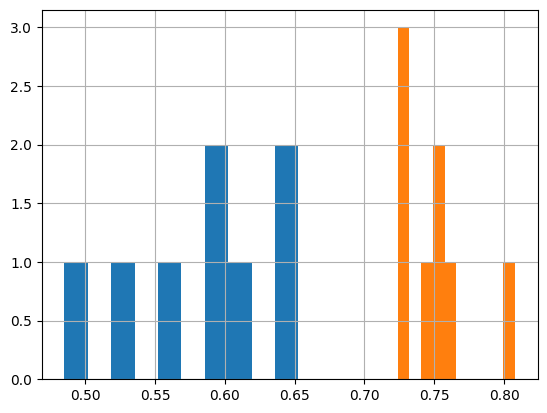

In [20]:
csid_df.sort_values('Acc.').head(8)['Acc.'].hist()
csid_df.sort_values('Acc.').tail(8)['Acc.'].hist()

In [21]:
for spk in res_dict.keys():
    df = pd.DataFrame(np.hstack(res_dict[spk])).T
    df['mis'] = df[0] + '-' + df[1]
    df[df[2]!='C']['mis'].value_counts().to_csv(f'{spk}.csv')